### Make Plots for Sparsity vs. Embedding-Sharing Parameters

In [ ]:
from src.data.utils import load_data, get_discretization
import torch

dataset = "foursquare_NYC"
n_users = 400

df, x_features, t_features = load_data(
    dataset=dataset,
    n_users=n_users,
)

df['cell-1'] = df.groupby('point', sort=False).ngroup() + 1

In [ ]:
def get_cell_saturation_curve(
    loc_level,
    target_visits=5,
    step_size=100,
    discretization_rows=200,
    n_visits=100_000,
    grow_factor=4,
    metric='sparsity'
):
    df_quantized = get_discretization(
        df,
        n_rows=discretization_rows,
        shape="hex",
        aggregation_mode="grow",
        grow_factor=grow_factor,
    )
    cell_visits = df_quantized[f"cell{loc_level}"].iloc[:n_visits]
    cell_idcs = cell_visits.values
    n_unique = cell_visits.nunique()
    idcs_chunks = torch.tensor(cell_idcs.reshape(-1, step_size))
    value_counts = torch.zeros(idcs_chunks.shape[0], n_unique)
    value_counts = value_counts.scatter_add_(
        1, idcs_chunks - 1, torch.ones_like(value_counts)
    )
    cum_value_counts = value_counts.cumsum(0)
    if metric == 'sparsity':
        return 1- torch.mean((cum_value_counts >= target_visits).to(torch.float32), dim=-1)
    elif metric == 'median_checkins':
        return torch.quantile(cum_value_counts, 0.5, dim=-1)
    elif metric == 'mean_checkins':
        return torch.mean(cum_value_counts, dim=-1)

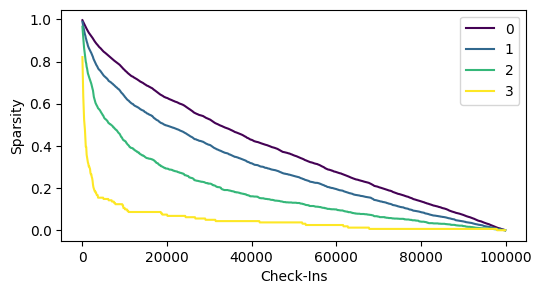

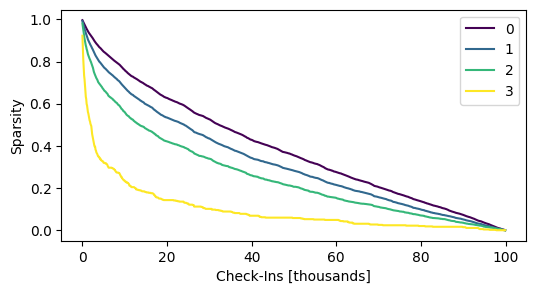

In [ ]:
step_size = 100
cmap = plt.get_cmap("viridis", 4)
colors = cmap(range(4))

fig, ax = plt.subplots(figsize=(6, 3))
for loc_level in range(4):
    y = get_cell_saturation_curve(
        loc_level=loc_level-1,
        discretization_rows=200,
        target_visits=1,
        step_size=step_size,
    )

    x = np.arange(len(y)) * step_size
    ax.plot(x, y, color=colors[loc_level], label=loc_level)

ax.set_xlabel("Check-Ins")
ax.set_ylabel("Sparsity")
ax.legend()

fig, ax = plt.subplots(figsize=(6, 3))
for loc_level in range(4):
    y = get_cell_saturation_curve(
        loc_level=loc_level-1,
        discretization_rows=400,
        target_visits=1,
        step_size=step_size,
    )

    x = np.arange(len(y)) * step_size / 1000
    ax.plot(x, y, color=colors[loc_level], label=loc_level)

ax.set_xlabel("Check-Ins [k]")
ax.set_ylabel("Sparsity")
ax.legend()


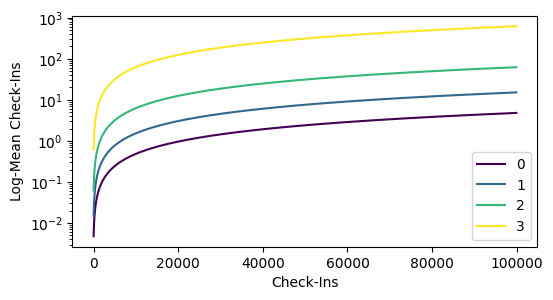

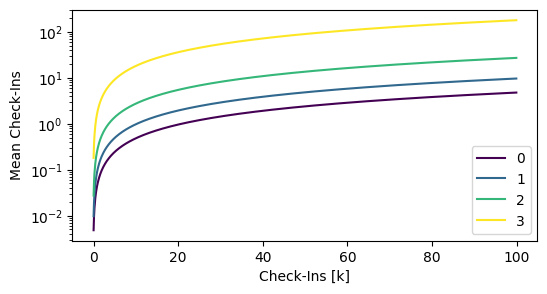

In [ ]:
step_size = 100
cmap = plt.get_cmap("viridis", 4)
colors = cmap(range(4))

fig, ax = plt.subplots(figsize=(6, 3))
for loc_level in range(4):
    y = get_cell_saturation_curve(
        loc_level=loc_level-1,
        discretization_rows=200,
        target_visits=1,
        step_size=step_size,
        metric='mean_checkins'
    )

    x = np.arange(len(y)) * step_size
    ax.plot(x, y, color=colors[loc_level], label=loc_level)


ax.set_yscale("log")
ax.set_xlabel("Check-Ins")
ax.set_ylabel("Log-Mean Check-Ins")
ax.legend()

fig, ax = plt.subplots(figsize=(6, 3))
for loc_level in range(4):
    y = get_cell_saturation_curve(
        loc_level=loc_level-1,
        discretization_rows=400,
        target_visits=1,
        step_size=step_size,
        metric='mean_checkins'
    )

    x = np.arange(len(y)) * step_size / 1000
    ax.plot(x, y, color=colors[loc_level], label=loc_level)

ax.set_yscale("log")
ax.set_xlabel("Check-Ins [k]")
ax.set_ylabel("Mean Check-Ins")
ax.legend()



In [ ]:
# Function to calculate entropy
def entropy(column):
    # Probability of each unique value
    probabilities = column.value_counts(normalize=True)
    # Entropy formula: H = -Σ P(x) * log2(P(x))
    return -np.sum(probabilities * np.log2(probabilities))


# Function to calculate conditional entropy
def conditional_entropy(df, feature_col, target_col):
    probas_as = df[feature_col].value_counts(normalize=True).values
    h_b_given_as = np.array([entropy(dfg[target_col]) for _, dfg in df.groupby(feature_col)])
    return np.sum(probas_as * h_b_given_as)



# Function to compute information gain
def information_gain(df, feature_col, target_col):
    h_b = entropy(df[target_col])  # Entropy of target
    h_b_given_a = conditional_entropy(
        df, feature_col, target_col
    )  # Conditional entropy
    return h_b - h_b_given_a


# Compute information gain of 'Feature' w.r.t. 'Target'
ig = information_gain(df, "cell-1", "user")
ig

np.float64(7.7718731147408135)

In [ ]:
mean_value_counts = {}
igs = {}
datasets = [
    "foursquare_NYC", "foursquare_TKY",
     "geolife"]
for dataset in datasets:
    n_users = 150 if dataset == "geolife" else 800
    n_rows = 800 if dataset == 'geolife' else 200
    df, _, _ = load_data(dataset=dataset, n_users=n_users)
    if dataset != "geolife":
        df["cell-1"] = df.groupby("point", sort=False).ngroup() + 1
    df = df.iloc[:50_000]
    df_quantized = get_discretization(
        df,
        n_rows=n_rows,
        shape="hex",
        aggregation_mode="grow",
        grow_factor=grow_factor,
    )
    mean_value_counts[dataset] = []
    igs[dataset] = []
    for loc_level in range(4):
        lev = loc_level - 1 if dataset != "geolife" else loc_level
        print(f"{dataset}, loc_level {loc_level}")
        mean_value_counts[dataset].append(
            np.mean(df_quantized[f"cell{lev}"].value_counts())
        )
        igs[dataset].append(information_gain(df_quantized, f"cell{lev}", "user"))


foursquare_NYC, loc_level 0
foursquare_NYC, loc_level 1
foursquare_NYC, loc_level 2
foursquare_NYC, loc_level 3
foursquare_TKY, loc_level 0
foursquare_TKY, loc_level 1
foursquare_TKY, loc_level 2
foursquare_TKY, loc_level 3
geolife, loc_level 0
geolife, loc_level 1
geolife, loc_level 2
geolife, loc_level 3


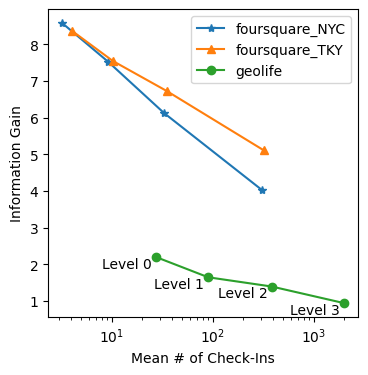

In [ ]:
fig, ax = plt.subplots(1, figsize=(4, 4))
markers = ['*', "^", "s"]
for idx, dataset in enumerate(datasets):
    x = mean_value_counts[dataset]
    y = igs[dataset]
    ax.plot(x, y, label=dataset, marker=markers[idx])
    if dataset == 'geolife':
        for i, (xi, yi) in enumerate(zip(x, y)):
            ax.text(xi, yi, f"Level {i} ", horizontalalignment='right', verticalalignment='top')
ax.set_xlabel("Mean # of Check-Ins")
ax.set_ylabel("Information Gain")
ax.set_xscale('log')
ax.legend()